<a id="1"></a> <br>
# Unsupervised Learning with Auto-Encoders

If you are interested in an introduction to auto-encoders, head over to [Julien Despois' article](https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df).
If a more technical breakdown is what you are looking for, check out [Lilian Weng's blog post](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html) from which the below image is sourced.
It illustrates the functioning of an auto-encoder for MNIST images, but the concept is the same.
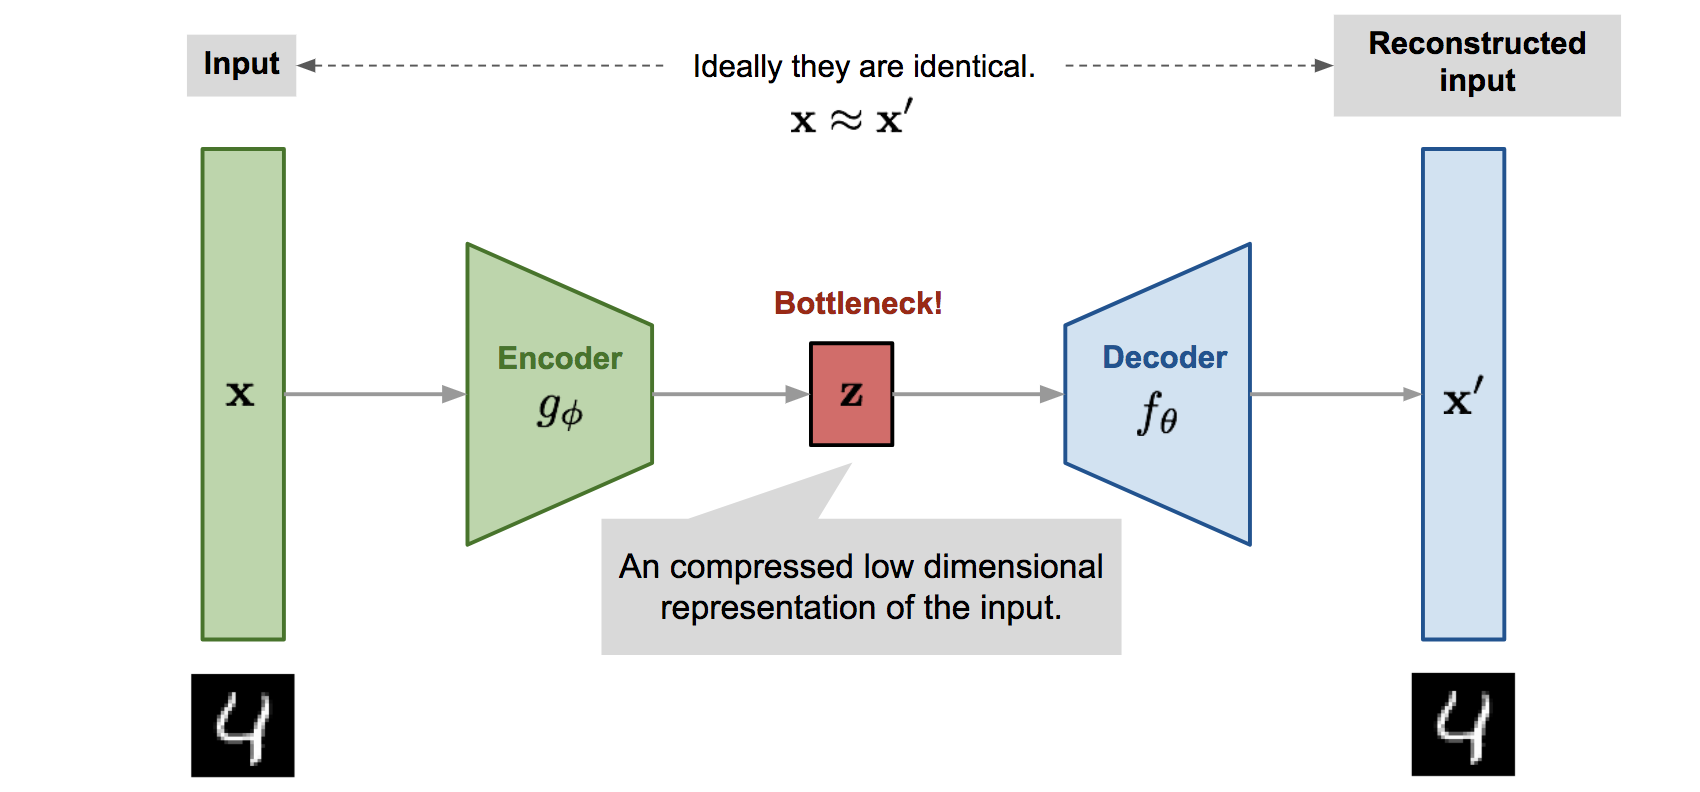

The idea is quite straightforward:
1. Due to the **bottleneck architecture** of the neural network, it is forced to learn a **condensed representation** from which to reproduce the original input.
2. We feed it **only normal transactions**, which it will learn to reproduce with high fidelity.
3. As a consequence, if a **fraud transaction is sufficiently distinct** from normal transactions, the auto-encoder will have trouble reproducing it with its learned weights, and the subsequent **reconstruction loss will be high**.
4. Anything above a specific loss (treshold) will be **flagged as anomalous** and thus labeled as fraud.

<a id="2"></a> <br>
# Preprocessing

## Import Libraries & set Random Seeds

In [2]:
# read & manipulate data
import pandas as pd 
import numpy as np
import tensorflow as tf

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib notebook

# misc
import random as rn

# load the dataset
df = pd.read_csv('../input/creditcard.csv')

# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

## Renaming columns

In [3]:
# let's quickly convert the columns to lower case and rename the Class column 
# so as to not cause syntax errors
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)

# print first 5 rows to get an initial impression of the data we're dealing with
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Calculated field: log10(amount)

Turn the amount feature into a normally distributed log equivalent.

In [4]:
# add a negligible amount to avoid taking the log of 0
df['log10_amount'] = np.log10(df.amount + 0.00001)

In [5]:
# keep the label field at the back
df = df[
    [col for col in df if col not in ['label', 'log10_amount']] + 
    ['log10_amount', 'label']
]
df

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v22,v23,v24,v25,v26,v27,v28,amount,log10_amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,2.174990,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.429754,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,2.578249,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,2.091667,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,1.845036,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0.564667,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0.698101,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,1.610660,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,1.969416,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0.565849,0


## Undersampling the non-fraud
To keep the computation time low, let's feed t-SNE only a small subsample (undersampling the clean transactions).

In [6]:
# manual parameter 
RATIO_TO_FRAUD = 15

# dropping redundant columns
df = df.drop(['time', 'amount'], axis=1)

# splitting by class
fraud = df[df.label == 1]
clean = df[df.label == 0]

# undersample clean transactions
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED
)

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('label', axis=1).values, \
                   visualisation_initial.label.values

In [7]:
print(f"""The non-fraud dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}.
This represents a ratio of {RATIO_TO_FRAUD}:1 to fraud.""")

The non-fraud dataset has been undersampled from 284,315 to 7,380.
This represents a ratio of 15:1 to fraud.


<a id="4"></a> <br>
# Train/Validate/Test split
Our auto-encoder will **only train on transactions that were normal**. 
What's left over will be combined with the fraud set to form our test sample.

We will be doing something akin to the below:
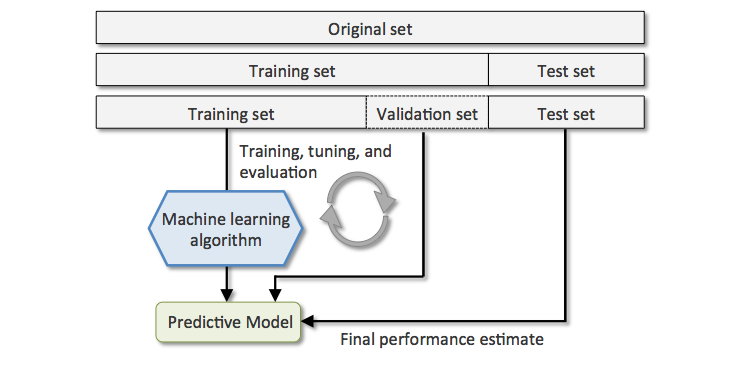
 

1. Training: only non-fraud
    * Split into:
        1. Actual training of our autoencoder
        2. Validation of the neural network's ability to generalize
2. Testing : mix of fraud and non-fraud
    * Treated like new data
    * Attempt to locate outliers
        1. Compute reconstruction loss
        2. Apply threshold

In [8]:
print(f"""Shape of the datasets:
    clean (rows, cols) = {clean.shape}
    fraud (rows, cols) = {fraud.shape}""")

Shape of the datasets:
    clean (rows, cols) = (284315, 30)
    fraud (rows, cols) = (492, 30)


In [9]:
# shuffle our training set
clean = clean.sample(frac=1).reset_index(drop=True)

# training set: exlusively non-fraud transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('label', axis=1)

# testing  set: the remaining non-fraud + all the fraud 
X_test = clean.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)

In [10]:
print(f"""Our testing set is composed as follows:

{X_test.label.value_counts()}""")

Our testing set is composed as follows:

0    84315
1      492
Name: label, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

In [12]:
X_test.shape

(84807, 29)

## Summary

In [13]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (160000, 29)
    validate (rows, cols) = (40000, 29)
    holdout  (rows, cols) = (84807, 29)


## Building our pipeline

In [14]:
from sklearn.preprocessing import Normalizer, MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
######pipeline=StandardScaler()

## Fitting the pipeline

In [15]:
# get normalization parameters by fitting to the training data
pipeline.fit(X_train);

## Applying transformations with acquired parameters

In [16]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

## Architecture of our model
Keras has become the standard high-level API within Tensorflow. No surprise, it's awesome.
Check out their [blog post on the topic of autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html).

In [17]:
# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 29)                870       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 4

## Training

In [18]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Train on 160000 samples, validate on 40000 samples
Epoch 1/100
160000/160000 [==============================] - 3s 21us/sample - loss: 0.0299 - acc: 0.2403 - val_loss: 0.0157 - val_acc: 0.3120
Epoch 2/100
160000/160000 [==============================] - 2s 15us/sample - loss: 0.0151 - acc: 0.3341 - val_loss: 0.0148 - val_acc: 0.3444
Epoch 3/100
160000/160000 [==============================] - 2s 14us/sample - loss: 0.0146 - acc: 0.3484 - val_loss: 0.0145 - val_acc: 0.3454
Epoch 4/100
160000/160000 [==============================] - 2s 15us/sample - loss: 0.0144 - acc: 0.3490 - val_loss: 0.0143 - val_acc: 0.3532
Epoch 5/100
160000/160000 [==============================] - 2s 15us/sample - loss: 0.0142 - acc: 0.3502 - val_loss: 0.0142 - val_acc: 0.3522
Epoch 6/100
160000/160000 [==============================] - 3s 16us/sample - loss: 0.0141 - acc: 0.3453 - val_loss: 0.0140 - val_acc: 0.3406
Epoch 7/100
160000/160000 [==============================] - 2s 15us/sample - loss: 0.0139 - acc:

<a id="7"></a> <br>
# Reconstructions

We **apply the transformation pipeline to our test set**. <br>
Then, we **pass the data through the trained autoencoder**.

In [19]:
# transform the test set with the pipeline fitted to the training set
#####pipeline.fit(X_test)
X_test_transformed = pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

**Calculate the reconstruction loss** for every transaction and draw a sample.

In [20]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

In [21]:
mse

array([0.00671974, 0.00663162, 0.00579422, ..., 0.012049  , 0.01864207,
       0.0071888 ])

In [22]:
y_test==1

array([False, False, False, ..., False, False, False])

In [23]:
clean = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

Very promising! Although some transactions seem to fool the autoencoder, the fraudulent transactions clearly have a distinguishing element in their data that sets them apart from clean ones. 

<a id="8"></a> <br>
# Setting a threshold for classification

## Unsupervised
Normally, in an unsupervised solution, this is where the story would end. We would **set a threshold that limits the amount of false positives** to a manageable degree, **and captures the most anomalous data points**.

### Percentiles 
We could set this threshold by taking the top x% of the dataset and considering it anomalous.

### MAD
We could also use a **modified Z-score using the Median Absolute Deviation to define outliers** on our reconstruction data. Here is a [good blog post on the topic](https://medium.com/james-blogs/outliers-make-us-go-mad-univariate-outlier-detection-b3a72f1ea8c7) by João Rodrigues, illustrating why this algorithm is more robust and scalable than the percentiles method.

In [24]:
THRESHOLD = 3

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [25]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 1,654 outliers in a total of 84,807 transactions [1.95%].


## Supervised
We know the labels, so we can verify our results.

### Classification Matrix on MAD outliers
A closer look:

In [26]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

In [27]:

print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as fraud that were actual fraud(precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=3 are as follows:
[[83022  1293]
 [  131   361]]

% of transactions labeled as fraud that were actual fraud(precision): 361/(1293+361) = 21.83%
% of fraudulent transactions were caught succesfully (recall):    361/(131+361) = 73.37%


In [28]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

# get (mis)classification
cm = confusion_matrix(outliers,y_test)

# true/false positives/negatives
(tn, fn, 
 fp, tp) = cm.flatten()

In [29]:
clean = z_scores[y_test==0]
fraud = z_scores[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("Distribution of the modified z-scores")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>